In [ ]:
!pip install tqdm -q


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 10.8 MB/s eta 0:00:00


In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
!pip install nltk


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import string
from gensim.models import Word2Vec

In [2]:
import pandas as pd

In [9]:
from tqdm import tqdm

# Cargar el archivo CSV
ruta_csv = "spotify_dataset_sin_duplicados_4.csv"

try:
    df = pd.read_csv(ruta_csv)

    # Asegurar que existe la columna 'text'
    if 'text' not in df.columns:
        raise ValueError("La columna 'text' no se encuentra en el archivo CSV.")

    # Extraer las letras de las canciones a una lista
    todas_las_canciones = []

    for texto in tqdm(df['text'].fillna("")):
        todas_las_canciones.append(texto)

    print("Letras extraídas con éxito.")
except Exception as e:
    print(f"Error al cargar o procesar el archivo CSV: {e}")


100%|██████████| 108138/108138 [00:00<00:00, 1918473.75it/s]

Letras extraídas con éxito.


In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-zA-Z\s]", "", texto)
    tokens = texto.split()  # En lugar de word_tokenize
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

corpus = [preprocesar_texto(letra) for letra in todas_las_canciones]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dylan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dylan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import random
import numpy as np

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

from gensim.models.word2vec import Word2Vec
Word2Vec.seed = SEED

from gensim.models import Word2Vec

modelo_w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4, seed=SEED)

In [4]:

def vector_promedio(tokens, modelo):
    vectores = [modelo.wv[word] for word in tokens if word in modelo.wv]
    if len(vectores) == 0:
        return np.zeros(modelo.vector_size)
    return np.mean(vectores, axis=0)

vectores_canciones = np.array([vector_promedio(tokens, modelo_w2v) for tokens in corpus])

NameError: name 'corpus' is not defined

In [ ]:
# Guardar en formato word2vec compatible con Gensim
with open("canciones_embeddings.txt", "w", encoding="utf-8") as f:
    f.write(f"{len(vectores_canciones)} {modelo_w2v.vector_size}\n")
    for idx, vec in enumerate(vectores_canciones):
        vector_str = ' '.join(map(str, vec))
        f.write(f"cancion_{idx} {vector_str}\n")

In [5]:
from gensim.models import KeyedVectors

# Cargar vectores guardados
embeddings_cargados = KeyedVectors.load_word2vec_format("canciones_embeddings.txt", binary=False)

# Obtener vector de la canción 6528
vec = embeddings_cargados["cancion_6528"]

# Recalcular matriz de vectores si es necesario
vectores_canciones = np.array([embeddings_cargados[f"cancion_{i}"] for i in range(len(embeddings_cargados))])

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

def recomendar(idx_cancion, vectores, top_n=4):
    similitudes = cosine_similarity([vectores[idx_cancion]], vectores)[0]
    indices_similares = similitudes.argsort()[::-1][1:top_n+1]
    return indices_similares, similitudes[indices_similares]

In [32]:
indices, similitudes = recomendar(3149, vectores_canciones)

print("Canciones recomendadas similares a la 0:")
for i, score in zip(indices, similitudes):
    print(f"Canción {i} (similitud: {score:.2f})")

Canciones recomendadas similares a la 0:
Canción 29066 (similitud: 0.99)
Canción 28570 (similitud: 0.97)
Canción 80389 (similitud: 0.88)
Canción 86637 (similitud: 0.88)


In [33]:
id_cancion = 3149  # Cambia esto según la canción base que elijas
# Mostrar la canción base
print("🔍 Canción base:")
print(f"{df.loc[id_cancion, 'song']} - {df.loc[id_cancion, 'Artist(s)']} - {df.loc[id_cancion, 'Genre']}")
print()

# Mostrar recomendaciones
print("🎧 Canciones recomendadas:")
for i in indices:
    print(f"{df.loc[i, 'song']} - {df.loc[i, 'Artist(s)']} - {df.loc[i, 'Genre']}")


🔍 Canción base:
Spanish Eyes - Al Martino - hip hop

🎧 Canciones recomendadas:
Spanish Eyes - Engelbert Humperdinck - pop
Spanish Eyes - Elvis Presley - blues,gospel,pop rock
Sad Eyes - Robert John - soundtrack,classical,jazz
Ocean In Your Eyes - Smokey Robinson & The Miracles - soul,rnb


In [34]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import Image, display, HTML

# 🔐 Autenticación con la API de Spotify
client_id = "9d74d56ab0c5436ca827b968e647b1ca"
client_secret = "db476f73e50b473bac2fa02fe820e635"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

def obtener_html_portada(song_name, album_name, artist_name, genre=None, similitud=None, release_date_dataset=None, emotion=None):
    image_url = None
    spotify_release_date = "No disponible"

    # Nivel 1: track + album + artist
    query = f"track:{song_name} album:{album_name} artist:{artist_name}"
    result = sp.search(q=query, type='track', limit=1)

    if result['tracks']['items']:
        track = result['tracks']['items'][0]
        image_url = track['album']['images'][0]['url'] if track['album']['images'] else None
        spotify_release_date = track['album'].get('release_date', "No disponible")
    else:
        # Nivel 2: album + artist
        query = f"album:{album_name} artist:{artist_name}"
        result = sp.search(q=query, type='album', limit=1)
        if result['albums']['items']:
            album = result['albums']['items'][0]
            image_url = album['images'][0]['url'] if album['images'] else None
            spotify_release_date = album.get('release_date', "No disponible")
        else:
            # Nivel 3: solo album
            query = f"album:{album_name}"
            result = sp.search(q=query, type='album', limit=1)
            if result['albums']['items']:
                album = result['albums']['items'][0]
                image_url = album['images'][0]['url'] if album['images'] else None
                spotify_release_date = album.get('release_date', "No disponible")
            else:
                # Nivel 4: solo artist
                query = f"artist:{artist_name}"
                result = sp.search(q=query, type='artist', limit=1)
                if result['artists']['items']:
                    artist = result['artists']['items'][0]
                    if artist.get('images'):
                        image_url = artist['images'][0]['url']

    # Construir HTML
    if image_url:
        html = f"""
        <div style="display:inline-block; text-align:center; margin:10px; width:150px">
            <img src="{image_url}" width="150" style="border-radius:8px"><br>
            <b>{song_name}</b><br>
            <small>{artist_name}</small><br>
            <small>{genre if genre else ''}</small><br>
            <small>📅 {release_date_dataset}</small><br>
            <small>🗓 {spotify_release_date}</small><br>
            {'<small>🔗 %.2f</small>' % similitud if similitud else ''}<br>
            {'<small>🎭 %s</small>' % emotion if emotion else ''}
        </div>
        """
    else:
        html = f"""
        <div style="display:inline-block; text-align:center; margin:10px; width:150px">
            <div style="width:150px;height:150px;background:#ccc;border-radius:8px;"></div>
            <b>{song_name}</b><br>
            <small>{artist_name}</small><br>
            <small>No se encontró imagen</small>
        </div>
        """
    return html


id_cancion = 90936

# Canción base
print("🔍 Canción base:")
nombre_cancion = df.loc[id_cancion, 'song']
nombre_album = df.loc[id_cancion, 'Album']
artista = df.loc[id_cancion, 'Artist(s)']
genero = df.loc[id_cancion, 'Genre']
fecha = df.loc[id_cancion, 'Release Date']
emotion = df.loc[id_cancion, 'emotion']

html_cancion_base = obtener_html_portada(nombre_cancion, nombre_album, artista, genero, None, fecha, emotion)
display(HTML(html_cancion_base))

# Recomendaciones
indices, similitudes = recomendar(id_cancion, vectores_canciones)

print("🎧 Canciones recomendadas:")
html_resultados = ""

for i, sim in zip(indices, similitudes):
    nombre_cancion = df.loc[i, 'song']
    nombre_album = df.loc[i, 'Album']
    artista = df.loc[i, 'Artist(s)']
    genero = df.loc[i, 'Genre']
    fecha = df.loc[i, 'Release Date']
    emotion = df.loc[i, 'emotion']
    html_resultados += obtener_html_portada(nombre_cancion, nombre_album, artista, genero, sim, fecha, emotion)

# Mostrar en galería horizontal
display(HTML(html_resultados))



🔍 Canción base:


🎧 Canciones recomendadas:


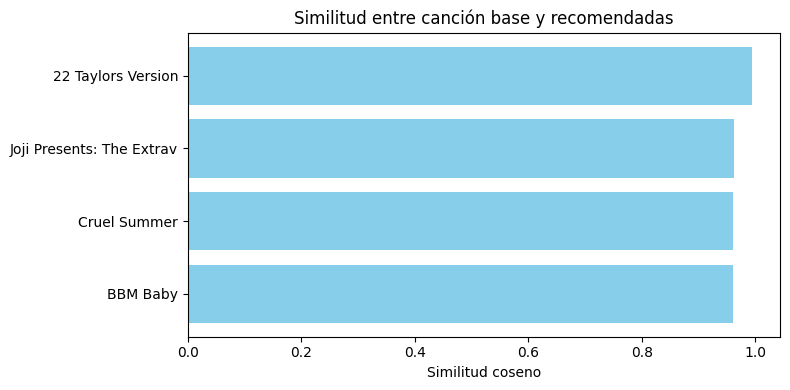

In [35]:
import matplotlib.pyplot as plt

# Visualizar similitud
plt.figure(figsize=(8, 4))
plt.barh(range(len(similitudes)), sorted(similitudes, reverse=True), color='skyblue')
plt.yticks(range(len(similitudes)), [f"{df.loc[i, 'song']}"[:25] for i in indices])
plt.xlabel('Similitud coseno')
plt.title('Similitud entre canción base y recomendadas')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [36]:
recomendaciones = pd.DataFrame({
    'Canción': [df.loc[i, 'song'] for i in indices],
    'Artista': [df.loc[i, 'Artist(s)'] for i in indices],
    'Género': [df.loc[i, 'Genre'] for i in indices],
    'Similitud': [round(score, 3) for score in similitudes]
})

# Mostrar tabla ordenada
display(recomendaciones)


,Canción,Artista,Género,Similitud
0,22 Taylors Version,Taylor Swift,"pop,country,electropop",0.994
1,Joji Presents: The Extravaganza,Joji,hip hop,0.962
2,Cruel Summer,Taylor Swift,"pop,country,electropop",0.961
3,BBM Baby,Lana Del Rey,"electronic,pop,alternative",0.960
